## 使用 CNN 破解驗證碼

### 下載資料集

In [1]:
! wget https://raw.githubusercontent.com/ywchiu/tibamedl/master/data/captcha_jpg.zip

--2020-05-12 06:07:08--  https://raw.githubusercontent.com/ywchiu/tibamedl/master/data/captcha_jpg.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3818150 (3.6M) [application/zip]
Saving to: ‘captcha_jpg.zip’

captcha_jpg.zip     100%[===================>]   3.64M  11.9MB/s    in 0.3s    

2020-05-12 06:07:09 (11.9 MB/s) - ‘captcha_jpg.zip’ saved [3818150/3818150]



In [0]:
! unzip captcha_jpg.zip > 1.log

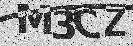

In [3]:
from PIL import Image
Image.open('data/994.jpg')

In [0]:
import pandas
captcha =  pandas.read_csv('https://raw.githubusercontent.com/ywchiu/tibamedl/master/Data/output_captua.csv', usecols=['captcua', 'file'])
captcha.columns = ['captcha', 'file']

In [7]:
captcha.tail(6)

,captcha,file
993,m3cz,994.0
994,q93a,995.0
995,r9m5,996.0
996,5n4m,997.0
997,tj94,998.0
998,zhaz,999.0


In [0]:
captcha = captcha[captcha['file'].notnull()]

In [0]:
captcha['file'] = captcha['file'].map(lambda e: 'data/{}.jpg'.format(int(e)) )

In [0]:
captcha.reset_index(inplace=True)
del captcha['index']

In [12]:
#captcha.head()
captcha.tail(6)

,captcha,file
992,m3cz,data/994.jpg
993,q93a,data/995.jpg
994,r9m5,data/996.jpg
995,5n4m,data/997.jpg
996,tj94,data/998.jpg
997,zhaz,data/999.jpg


In [18]:
from PIL import Image
import numpy as np
img = Image.open('data/2.jpg')
img = img.resize((135,47))
#img
im = np.array(img)
im.shape

(47, 135, 3)

### 建立 X 與 Y

In [19]:
characters = '0123456789abcdefghijklmnopqrstuvwxyz'
height, width = 47,135
n_len = 4
n_class = len(characters)
print(height, width, n_class,n_len)

47 135 36 4


In [20]:
X = np.zeros((len(captcha), height, width, 3), dtype=np.float32)
y = [np.zeros((len(captcha), n_class), dtype=np.uint8) for i in range(n_len)]
X.shape, y[0].shape, len(y)

((998, 47, 135, 3), (998, 36), 4)

In [0]:
for i in captcha.index:
    random_str = captcha.loc[i,'captcha']
    fname = captcha.loc[i,'file']
    img = Image.open(fname)
    img = img.resize((width, height))
    im = np.array(img)
    X[i] = im * 1.0 / 255.0
    for j, ch in enumerate(random_str):
        y[j][i, :] = 0
        y[j][i, characters.find(ch)] = 1

In [25]:
y[0][992]
y[1][992]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [0]:
import random
def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    while True:
        for i in range(batch_size):
            rand_index = random.choice(captcha.index)
            random_str = captcha.loc[rand_index,'captcha']
            fname = captcha.loc[rand_index,'file']
            img = Image.open(fname)
            img = img.resize((width, height))
            im = np.array(img)
            X[i] = im / 255.0

            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

### 建立 CNN 模型

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

In [0]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

In [0]:
input_tensor = Input((height, width, 3))

x = input_tensor
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x) 

x = Conv2D(256, (3, 3), activation='relu')(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x) 

x = Flatten()(x)
x = Dropout(0.25)(x)

In [30]:
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]

model = Model(inputs=input_tensor, outputs=x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 47, 135, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 45, 133, 64)  1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 43, 131, 64)  36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 21, 65, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [34]:
history = model.fit_generator(gen(batch_size=32),      # 每次生成器會產生32筆小批量的資料
                    epochs=5,                # 總共跑5個訓練循環
                    steps_per_epoch=1000,
                    #callbacks=cbks,          # 保存最好的模型到檔案
                    validation_data=gen(),   # 驗證資料也是用生成器來產生
                    validation_steps=40      # 用40組資料來驗證
                   )

Epoch 1/5
  37/1000 [>.............................] - ETA: 38:13 - loss: 11.7314 - c1_loss: 2.9293 - c2_loss: 2.9066 - c3_loss: 2.9608 - c4_loss: 2.9347 - c1_accuracy: 0.0794 - c2_accuracy: 0.0954 - c3_accuracy: 0.0819 - c4_accuracy: 0.1047

KeyboardInterrupt: ignored

In [0]:
model.save('captcha.h5')

In [36]:
import numpy as np
img = Image.open('data/995.jpg')
img = img.resize((135,47))
#img
im = np.array(img)
im.shape
#im

(47, 135, 3)

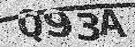

In [37]:
img

In [0]:
X_predict = np.zeros((1, height, width, 3), dtype=np.uint8)
X_predict[0] = im / 255.0

In [39]:
for p in model(X_predict):
  print(characters[(np.argmax(p.numpy()))])

k
a
3
7
